<font size=6><b>Lec04. Image Argumentation (이미지 증강)</b></font><br>
tfds.image_classification.FashionMNIST
<br>
* ref : https://keras.io/api/preprocessing/image/
* ref : https://www.tensorflow.org/datasets/catalog/fashion_mnist
* ref : 홈페이지 : https://github.com/zalandoresearch/fashion-mnist
* ref : 소스 코드 : https://github.com/tensorflow/datasets/tree/master/tensorflow_datasets/image_classification/mnist.py



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Activation                 #-------------FC
from keras.layers import Conv2D, MaxPooling2D,Flatten      #-------------CNN
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from keras.callbacks import EarlyStopping, ModelCheckpoint  #------------ callback

import warnings
warnings.filterwarnings(action='ignore')

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set()

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

# from sklearn.datasets import load_boston
from keras.datasets     import fashion_mnist


In [2]:
# flow 방식에서 없어도 된다.
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
#(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None)


# seed 고정

In [3]:
np.random.seed(1234)
tf.random.set_seed(1234)

# Data Load
* ref : https://github.com/teavanist/MNIST-JPGhttps://github.com/teavanist/MNIST-JPG

In [4]:
img_jpg_mnist



In [5]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()  # [(arr),(arr)]

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [7]:
pd.Series(y_train).value_counts()

9    6000
0    6000
3    6000
2    6000
7    6000
5    6000
1    6000
6    6000
4    6000
8    6000
dtype: int64

# EDA

In [8]:
LABEL__ = ['T-shirt/top','Trouser/pants','Pullover shirt','Dress','Coat',  'Sandal','Shirt','Sneaker','Bag','Ankle boot']

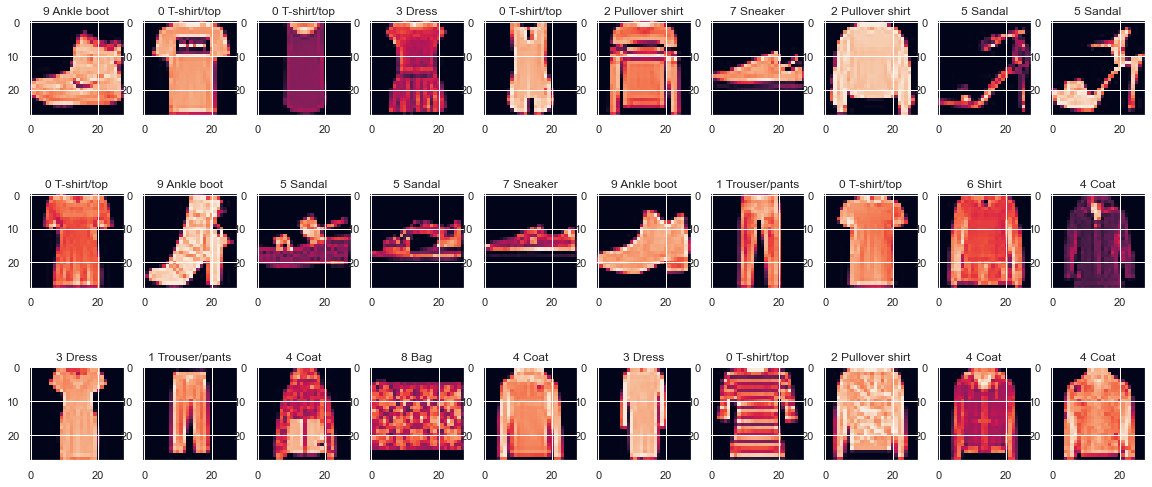

In [9]:
import matplotlib.pyplot as plt
p, axes = plt.subplots(3, 10, figsize=(20,9))

for i, x in enumerate( range(X_train[:30].shape[0])):  #range(30)):
    r = i // 10
    c = i % 10
    axes[r][c].imshow(X_train[x])   #, cmap=pyplot.get_cmap('gray'))
    axes[r][c].set_title(f"{y_train[x]} {LABEL__[y_train[x]]}" )
# plt.show()

# (Optional) 데이터 샘플링
* 속도 문제로 일부만 테스트

In [10]:
from sklearn.model_selection import train_test_split
print("원본:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(pd.Series(y_train).value_counts())


X_9, X_train, y_9, y_train = train_test_split(X_train, y_train, test_size=0.001, random_state=1234, stratify=y_train) # 분포 원본과 같게 하려고 stratify
X_9, X_test,  y_9, y_test  = train_test_split(X_test,  y_test,  test_size=0.001, random_state=1234, stratify=y_test)


print("원본0.001%:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(pd.Series(y_train).value_counts())

원본: (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
9    6000
0    6000
3    6000
2    6000
7    6000
5    6000
1    6000
6    6000
4    6000
8    6000
dtype: int64
원본0.001%: (60, 28, 28) (60,) (10, 28, 28) (10,)
2    6
8    6
3    6
7    6
5    6
4    6
9    6
0    6
1    6
6    6
dtype: int64


# 전처리 & 가공

## X피쳐 픽셀값 정규화
* 0 ~ 255 : 스케일링(MinMaxScaler)

In [11]:
X_train_scaler = X_train / 255.0
X_test_scaler  = X_test  / 255.0

* <font color=red><b>CNN 모델 : shape(이미지갯수, H, W, 컬러) </b></font>

In [12]:
X_train_scaler = X_train_scaler.reshape(-1, 28, 28, 1)    #1:흑백  3:RGB(컬러)
X_test_scaler  = X_test_scaler.reshape(-1, 28, 28, 1)     #1:흑백  3:RGB(컬러)
print(X_train_scaler.shape, X_test_scaler.shape)

(60, 28, 28, 1) (10, 28, 28, 1)


## y레이블 원핫인코딩
*  (integers in range 0-9)

In [13]:
y_train_oh = to_categorical( y=y_train, num_classes=10, dtype='int32')
y_test_oh  = to_categorical( y=y_test,  num_classes=10, dtype='int32')

# 이미지 증강 : 픽셀을 array(6000, 28, 28, 1) 값으로 가지고 있는 경우
* https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
* https://keras.io/ko/preprocessing/image/
* <font color=red size=4><b> ImageDataGenerator() --> generator.flow(X,y,batch_size=n)  --> fit() 또는 fit_generator() 또는 next()  
    * flow : 증강이미지 만듦. batchsize : 몇 개 이미지 만들어줄까
    * 과거에는 fit_generator, predict_generator 나눠져 있었음 -> 지금은 fit으로 다 합쳐지고 디플리케이트?(지금은 남아있는데 나중에 없어질 수 있다.)됨.(fit 안에 일반 fit 속성이랑, generator에만 쓰이는 속성 있다.)

## 이미지 보기

In [14]:
LABEL__[9], X_train_scaler.shape , X_test_scaler.shape # cnn 필터라 4차 이상 돼야 증강 가능

('Ankle boot', (60, 28, 28, 1), (10, 28, 28, 1))

## ImageDataGenerator()

<pre>
일부 몇 개만 건들지 모든 속성 건드려서 휘황찬란하게 할 필요 없다. -> 이러면 픽셀 분포가 커져서 오히려 러프하게 학습한다.
테스트 데이터에 있는 거 보고 결정. -> 리더보드에만 올리면 점수 낮아지면 아 좀 뒤집힌 애도 있고 하구나 하는 정도
generator = ImageDataGenerator(featurewise_center=False, samplewise_center=False, 
                               featurewise_std_normalization=False, 
                               samplewise_std_normalization=False, 
                               zca_whitening=False, zca_epsilon=1e-06, 
                               rotation_range=0, width_shift_range=0.0, 
                               height_shift_range=0.0, brightness_range=None, 
                               shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, 
                               fill_mode='nearest', cval=0.0, 
                               horizontal_flip=False, vertical_flip=False, 
                               rescale=None, 
                               preprocessing_function=None, 
                               data_format=None, 
                               validation_split=0.0, dtype=None)

In [15]:
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [16]:
#================================= train만 증강 ===========================================
train_generator = ImageDataGenerator( #rescale=1./255,             #----------0 ~ 255 : 스케일링(MinMaxScaler)
                                    featurewise_center=True,
                                    rotation_range=20,          # 0도~20도 범위 내에서확률적으로 돌려
                                    width_shift_range=0.2,      # 범위 내에서 확률적으로... 될 수도 있고 아닐 수도 있고
                                    height_shift_range=0.2,
                                    #horizontal_flip=True,
                                    #vertical_flip=True
                                    )

#================================= test 증강XXXXXXXXXXXXXXXXXXXXXx =========================
test_generator = ImageDataGenerator( ) #rescale=1./255 #----------0 ~ 255 : 스케일링(MinMaxScaler)

# test 안 해도 되는데 형식상 열어둠.
# directory채로 주면 보통 여기서 rescale한다.


## generator.flow(X,y,batch_size=n)
여기 batch랑 아까 batch랑 이름만 같다. / 몇 개 증강시켜줄까의 batch -> 가 아니라 같은 개념이래

<font color=red><b>*  이미지 증강을 위해선 4D array가 필요하다  shape(이미지갯수, H, W, 컬러)

In [17]:
X_train_scaler.shape , y_train_oh.shape

((60, 28, 28, 1), (60, 10))

* 1개 이미지를 읽어와 --> 4D array로 변형할 경우

In [18]:
# 한 개의 이미지만 가져오려고 하면 3차로 나와서 4차로 바꿔서 증강해야 한다.
# shape (장수(1장), H, W, 색)으로 만들기 위함.
print(X_train_scaler[0].shape, y_train_oh[0].shape)

#------------------------------------------------

one_img = np.array([X_train_scaler[0]])
# one_img = np.expand_dims(X_train_scaler[0], axis=0)
one_label = np.array([y_train_oh[0]])
print(one_img.shape, one_label.shape)

(28, 28, 1) (10,)
(1, 28, 28, 1) (1, 10)


* flow()

In [19]:
BATCH_SIZE__  = 10  #증강 이미지 갯수-> 총 개수 중에 이만큼만 랜덤으로 뽑아서 증강해. / 모델 돌릴 때의 batch_size와 같은 거
flow = train_generator.flow(X_train_scaler, y_train_oh, batch_size=BATCH_SIZE__)
img, label = flow.next() # .next 하면 한 번 돈다. -> epochs 돌면 계속 next 돼서 각 epoch때마다 batch_size만큼 생성. => 총 생성된 이미지 epochs*batch_size
print(len(img), len(label))

10 10


## 증강 이미지 확인

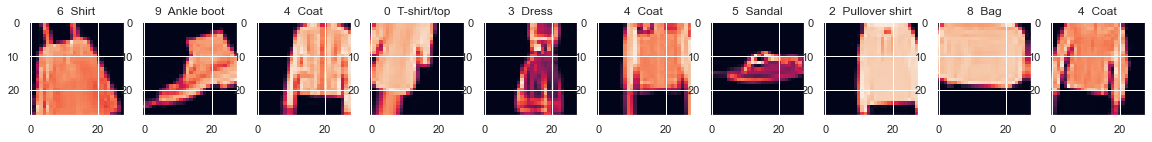

In [20]:
plt.figure(figsize=(20,3))
for i in range(len(img)):
    plt.subplot(1,10,i+1)
    plt.imshow(img[i])    #(28, 28, 1)
    plt.title(f"{np.argmax(label[i])}  {LABEL__[np.argmax(label[i])]}")
plt.show()

## 증강 이미지 저장하기 

In [21]:
import os
import shutil
FILE_PATH__ = "./img_aug_fmnist"

# 기존에 있으면 폴더,파일 모두 삭제 -> 주피터 여러 번 실행할까봐 안전장치
if os.path.exists(FILE_PATH__):
    shutil.rmtree(FILE_PATH__)

# 증강 이미지 저장 폴더 생성
if not os.path.exists(FILE_PATH__):
    os.mkdir(FILE_PATH__)

(28, 28, 1)


(-0.5, 27.5, 27.5, -0.5)

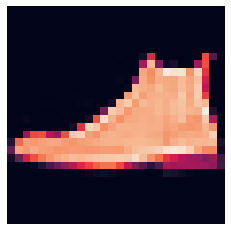

In [22]:
image9 = X_train_scaler[9]
plt.imshow(image9)
print(image9.shape)
plt.axis('off')

In [23]:
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img 

In [24]:
img_arr = img_to_array(image9)
img_arr = np.array([img_arr])  #3D --> 4D
print(img_arr.shape)

i = 0
flow2 = train_generator.flow(img_arr, 
                             batch_size=1, 
                             save_to_dir=FILE_PATH__,  #'./img_aug_fmnist',
                             save_prefix='aug_', save_format='png'
                            )    
for batch in flow2: # next하거나 루프 돌리면 된다. for batch 이거 필요 없는데 그냥 대충 써놓음.
    i += 1
    if i >= 20: 
        break  
        

(1, 28, 28, 1)


In [25]:
aug_img_list = os.listdir(FILE_PATH__)  #"./img_aug_fmnist"
print(len(aug_img_list), aug_img_list[:3])

20 ['aug__0_1585.png', 'aug__0_1888.png', 'aug__0_2381.png']


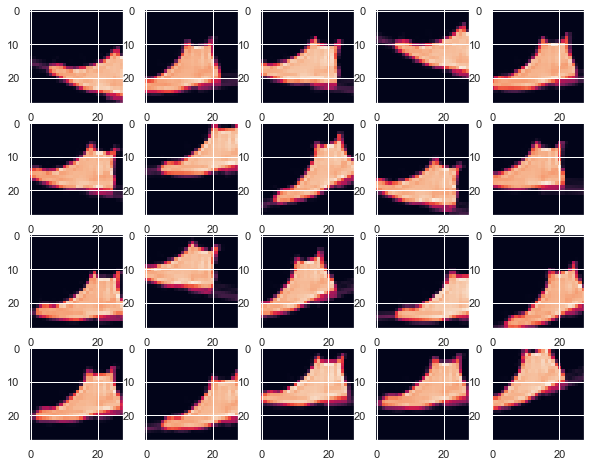

In [26]:
# 루프 20번 돌아서 20개 생김
columns = 5   
plt.figure(figsize=(10,10))
for i, augimg in enumerate(aug_img_list):
    augimg = plt.imread(os.path.join(FILE_PATH__, augimg))
    plt.subplot(5, columns, i + 1)
    plt.imshow(augimg)

# 증강 이미지 학습
* ref : https://gilbertlim.github.io/deep%20learning/dl_imagedatagenerator/

In [27]:
print("원본0.001%:", X_train_scaler.shape, y_train_oh.shape, X_test_scaler.shape, y_test_oh.shape)

원본0.001%: (60, 28, 28, 1) (60, 10) (10, 28, 28, 1) (10, 10)


In [28]:
input_shape = (28,28,1) #-----------------------------------★★★ 주의(Height, Width, Channel)
model = Sequential( [
        Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation="softmax")
        ] )
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [37]:
# 학습 -> 원래 했던 방식
history = model.fit(X_train_scaler, y_train_oh,                   
                    epochs=20,
                    batch_size=5,           # 5개 씩 끊어서 가져와
                    validation_split=0.2
                   )

print()
# 평가
loss, accuracy = model.evaluate(X_test_scaler, y_test_oh)
print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

Epoch 1/20
10/10 [==============================] - 0s 19ms/step - loss: 0.1071 - accuracy: 0.9583 - val_loss: 0.8125 - val_accuracy: 0.6667
Epoch 2/20
10/10 [==============================] - 0s 13ms/step - loss: 0.0586 - accuracy: 1.0000 - val_loss: 0.7760 - val_accuracy: 0.7500
Epoch 3/20
10/10 [==============================] - 0s 12ms/step - loss: 0.0683 - accuracy: 0.9792 - val_loss: 0.7587 - val_accuracy: 0.6667
Epoch 4/20
10/10 [==============================] - 0s 17ms/step - loss: 0.0479 - accuracy: 1.0000 - val_loss: 0.7913 - val_accuracy: 0.7500
Epoch 5/20
10/10 [==============================] - 0s 16ms/step - loss: 0.0555 - accuracy: 0.9792 - val_loss: 0.7777 - val_accuracy: 0.6667
Epoch 6/20
10/10 [==============================] - 0s 17ms/step - loss: 0.0529 - accuracy: 0.9792 - val_loss: 0.9030 - val_accuracy: 0.6667
Epoch 7/20
10/10 [==============================] - 0s 19ms/step - loss: 0.0333 - accuracy: 1.0000 - val_loss: 0.9545 - val_accuracy: 0.6667
Epoch 8/20
10

In [ ]:
# 학습 -> 증강 시 방식

In [38]:
batch_size = 5

###################################################################################################
# train 증강 옵션 설정
    # train용 기계
train_datagen = ImageDataGenerator(#rescale = 1./255, # 정규화
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   fill_mode = 'nearest',
                                   validation_split=0.2)  #----------8:2분리

# train 증강
    # train용 기계 돌리기
train_generator = train_datagen.flow(X_train_scaler, y_train_oh,  
                                     batch_size = batch_size, # 아까 5장 씩으로 해놨다.
                                     subset='training')                         # -------ImageDataGenerator에서 8:2 나눈 거에서 8 부분

###################################################################################################
# val 증강 (train 이미지 일부)
valid_generator = train_datagen.flow(X_train_scaler, y_train_oh,  
                                     batch_size = batch_size,
                                     subset='validation')                       # -------ImageDataGenerator에서 8:2 나눈 거에서 2 부분
                                          
###################################################################################################
# test 증강 옵션 설정
test_datagen = ImageDataGenerator() # test data에는 이미지 증강을 사용하지 않는다.
                                    # rescale = 1./255


# testl 증강 
test_generator = test_datagen.flow(X_test_scaler, y_test_oh,  
                                    batch_size = batch_size) # 데이터를 5개 씩 읽어들여라
         
###################################################################################################

# 학습

# 00000000예전 방식
# history = model.fit(X_train_scaler, y_train_oh,                   
#                     epochs=20,
#                     batch_size=5,           # 5개 씩 끊어서 가져와
#                     validation_split=0.2
#                    )

# 00000000증강 시 방식
history = model.fit(train_generator,
                  steps_per_epoch = len(X_train_scaler)*0.8//batch_size,       # steps_per_epoch : 각 에폭에서 몇 번 돌릴래(8에 해당하는 데이터를 배치사이즈로 나눈 만큼)(만들어진 개수)
                  epochs=20,
                  validation_data=valid_generator,
                  validation_steps = len(X_train_scaler)*0.2//batch_size)      # validation 만들어진 개수

print()
# 평가
loss, accuracy = model.evaluate(test_generator,  #test가아닌 test generator 넣는다.
                                steps = len(X_test_scaler)//batch_size) #뭉텅이로 갖고온다.
print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

Epoch 1/20
9/9 [==============================] - 0s 24ms/step - loss: 2.5375 - accuracy: 0.3953 - val_loss: 4.4252 - val_accuracy: 0.1000
Epoch 2/20
9/9 [==============================] - 0s 16ms/step - loss: 1.9888 - accuracy: 0.4186 - val_loss: 3.1312 - val_accuracy: 0.2000
Epoch 3/20
9/9 [==============================] - 0s 23ms/step - loss: 1.4529 - accuracy: 0.4884 - val_loss: 2.2166 - val_accuracy: 0.0000e+00
Epoch 4/20
9/9 [==============================] - 0s 24ms/step - loss: 1.3725 - accuracy: 0.5116 - val_loss: 1.3187 - val_accuracy: 0.6000
Epoch 5/20
9/9 [==============================] - 0s 26ms/step - loss: 1.4901 - accuracy: 0.4186 - val_loss: 2.3539 - val_accuracy: 0.1000
Epoch 6/20
9/9 [==============================] - 0s 23ms/step - loss: 1.4054 - accuracy: 0.3953 - val_loss: 1.9334 - val_accuracy: 0.1000
Epoch 7/20
9/9 [==============================] - 0s 28ms/step - loss: 1.2263 - accuracy: 0.5111 - val_loss: 2.5390 - val_accuracy: 0.0000e+00
Epoch 8/20
9/9 [===

In [40]:
# 증강전
# 1/1 [==============================] - 0s 48ms/step - loss: 2.1370 - accuracy: 0.5000
# Loss = 2.13699
# Accuracy = 0.50000

# 증강후
# 2/2 [==============================] - 0s 8ms/step - loss: 4.7667 - accuracy: 0.1000
# Loss = 4.76668
# Accuracy = 0.10000